# Transfer Learning with YAMNet

### Modelo Seleccionado

El Modelo seleccionado es __YAMNet__, el cual es un modelo que predice que [clases](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) de audios se le ingresa al modelo, teniendo 521 posibles clases de salida.

El modelo fue entrenado con el dataset de [AudioSet-YouTube corpus](http://g.co/audioset) y utiliza una arquitectura  [Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) la cual es una arquitectura convolucional depthwise-separable y se encuentra disponible en [TensorFlowHub](https://tfhub.dev/google/yamnet/1) 

In [47]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os, csv
import librosa
import scipy
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Se realiza el cargue del modelo pre-entrenado y se realiza una prueba con un audio de ejemplo

In [3]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

Se obtienen los nombres de las clases de salida del modelo

In [4]:
def class_names_from_csv(class_map):
    csv_file = tf.io.gfile.GFile(class_map)
    reader = csv.DictReader(csv_file)
    class_names = [row['display_name'] for row in reader]
    return class_names

In [5]:
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

Se asegura que el audio tenga la forma correcta para ser procesado por el modelo

In [6]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

Se importa un audio de prueba

In [7]:
# Load the sample audio file.
wav_path = './DataSets/Emotions/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Ensure that the sample rate is set to 16 kHz and calculate the sample length in seconds.
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Show some basic information about the audio.
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Listening to the wav file.
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


Se grafica el audio de prueba

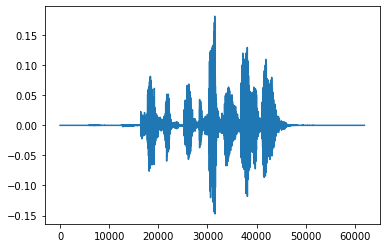

In [8]:
plt.plot(waveform)

Se realiza la predicción del modelo

In [9]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)

# Print the highest-scoring classes and their scores.
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
top_class = scores_np.mean(axis=0).argmax()
infered_class = class_names[top_class]

# results
print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (8, 1024)


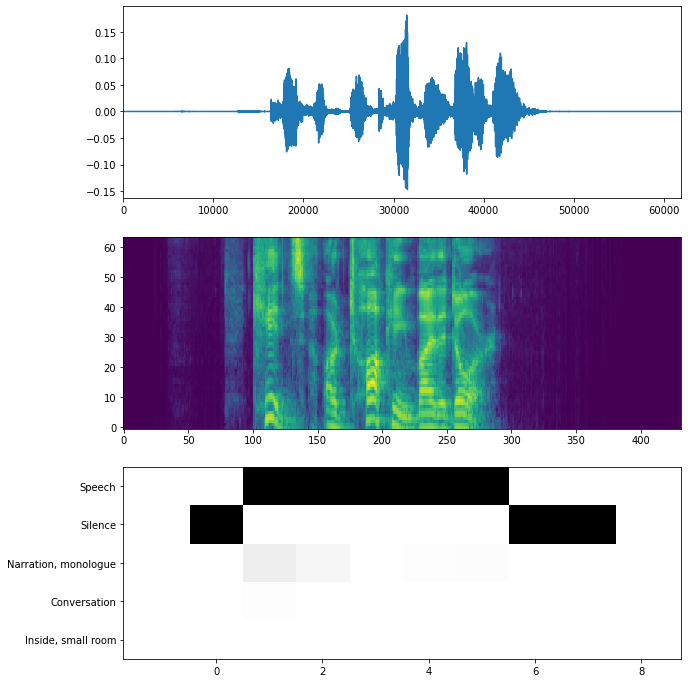

In [10]:
plt.figure(figsize=(10, 12))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 5
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# values from the model documentation
# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])

# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

Seleccionar un modelo pre-entrenado de tensorflow-hub y realizar la estrategia de aprendizaje por transferencia y fine-tuning con datos nuevos.

https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

In [13]:
DATASET = './DataSets/Emotions'
LABELS = ['Angry', 'Happy', 'Sad', 'Fearful', 'Disgusted', 'Neutral', 'Suprised']

In [14]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [16]:
X, y = [], []

for dirname, dirs, filenames in os.walk(DATASET):
    print(f'Processing {dirname}')
    for filename in filenames:
        path = os.path.join(dirname, filename)
        title = dirname.split('\\')[-1]
        category = LABELS.index(title)

        wav_data, sample_rate = librosa.load(path)
        wav_data = remove_silence(wav_data)
        if len(wav_data) == 0:
            continue

        waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
        scores, embeddings, spectrogram = yamnet_model(waveform)

        for embedding in embeddings:
            X.append(embedding)
            y.append(category)

Processing ./DataSets/Emotions
Processing ./DataSets/Emotions\Angry
Processing ./DataSets/Emotions\Disgusted
Processing ./DataSets/Emotions\Fearful
Processing ./DataSets/Emotions\Happy
Processing ./DataSets/Emotions\Neutral
Processing ./DataSets/Emotions\Sad
Processing ./DataSets/Emotions\Suprised


In [17]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((56592, 1024), (56592,))

In [36]:
def print_stadistics(stadistics):
    loss_values = stadistics.history['loss']
    val_loss_values = stadistics.history['val_loss']
    accuracy_values = stadistics.history['accuracy']
    val_accuracy_values = stadistics.history['val_accuracy']

    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.plot(epochs, accuracy_values, 'g', label='Training accuracy')
    plt.plot(epochs, val_accuracy_values, 'y', label='Validation accuracy')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.60, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.50, random_state=0)

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(LABELS))
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 7)                

In [59]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = "adam",
    metrics = ['accuracy']
)

In [60]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [61]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callback
)

Epoch 1/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.5801 - accuracy: 0.3494 - val_loss: 1.4591 - val_accuracy: 0.4097
Epoch 2/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.4419 - accuracy: 0.4161 - val_loss: 1.4030 - val_accuracy: 0.4358
Epoch 3/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.3757 - accuracy: 0.4444 - val_loss: 1.3771 - val_accuracy: 0.4452
Epoch 4/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.3375 - accuracy: 0.4614 - val_loss: 1.3706 - val_accuracy: 0.4458
Epoch 5/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.3024 - accuracy: 0.4776 - val_loss: 1.3599 - val_accuracy: 0.4588
Epoch 6/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.2676 - accuracy: 0.4893 - val_loss: 1.3409 - val_accuracy: 0.4642
Epoch 7/20
1062/1062 [==============================] - 6s 6ms/step - loss: 1.2359 - accuracy: 0.5027 - val_loss: 1.3542 - val_accuracy:

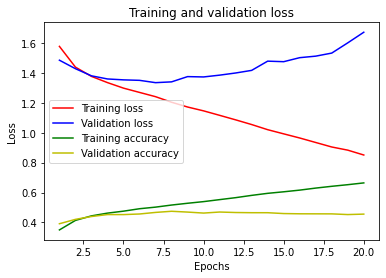

In [54]:
print_stadistics(history)

In [55]:
predictions = np.argmax(model.predict(X_test),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

354/354 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1920
           1       0.43      0.36      0.40      1834
           2       0.47      0.46      0.46      2094
           3       0.36      0.42      0.39      1745
           4       0.37      0.41      0.39      1797
           5       0.50      0.42      0.45      1560
           6       0.69      0.63      0.66       369

    accuracy                           0.46     11319
   macro avg       0.49      0.47      0.48     11319
weighted avg       0.46      0.46      0.46     11319



In [56]:
matrix = confusion_matrix(y_test, predictions)

<AxesSubplot:>

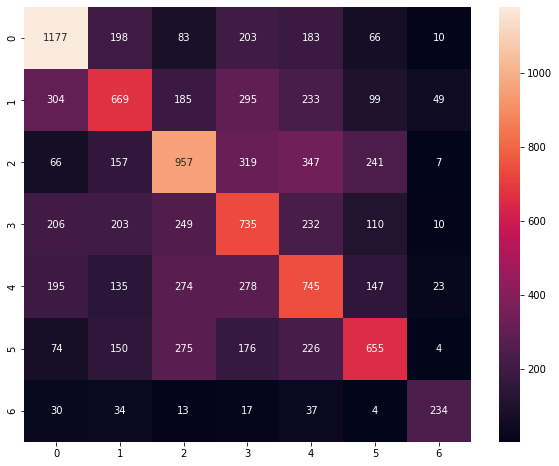

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d")